# Forward and backward pass (MLP)

## Team members:

* Project Manager - Kairat Kabdushev 
* Technical writer - Aruzhan Omarova 
* Author of executable content - Arnur Nurov
* Designer of interactive plots - Zhanibek Saduakas
* Designer of quizzes - Kairat Kabdushev 

# The architecture of neural network 

Allow us to briefly review the fundamental architecture of a neural network.

<img src="https://www.researchgate.net/publication/355373442/figure/fig1/AS:1080268202999810@1634567418319/Basic-structure-of-MLP-network-5.ppm" alt="Alt text" width="600">


- Inputs: $x_1$ -$x_n$ are the features of our data
- Weights: $w_{i_j}$, $w_{j_k}$, $w_{k_l}$, $w_{l_m}$ are some coefficients we multiply the inputs by
- Hidden layers: $h_1$ - $h_n$, $l_1$ - $l_n$ this is where the multiple neurons are stored to learn patterns in the data.
- Output: $y$ prediction/output of the training process

### Let's test what we have read

<img src="https://media.licdn.com/dms/image/C5112AQFOFj93r-blFg/article-cover_image-shrink_600_2000/0/1579777335853?e=2147483647&v=beta&t=02CL7iY48zpr9cQpGEyxXlsRGge-2KUArlRa8_4aJMM" alt="Alt text" width="600">

In [1]:
from jupyterquiz import display_quiz
display_quiz("#q_n_layers")

<IPython.core.display.Javascript object>

### To advance within this chapter, it is imperative to contemplate the data that will be utilized to implement our theoretical understanding. 

This dataset was created by Yaroslav Bulatov by taking some publicly available fonts and extracting glyphs from them to make a dataset similar to MNIST. There are 10 classes, with letters A-J. [Yaroslav Bulatov](https://www.linkedin.com/in/yaroslav-bulatov-862b3b1/)

Training images shape: (60000, 28, 28)
Training labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


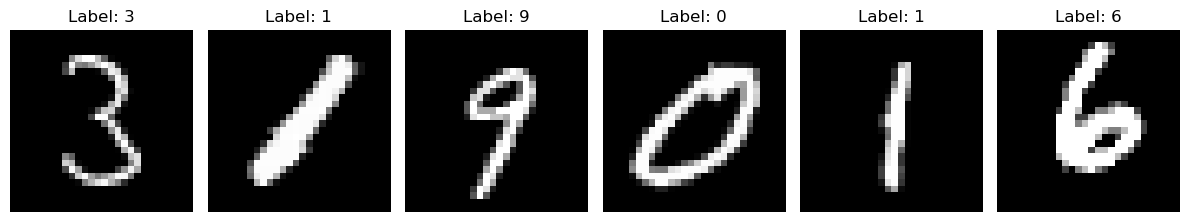

In [8]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

import numpy as np
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import plotly.express as px
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import plotly.graph_objects as go
from tensorflow.keras.utils import to_categorical
import ipywidgets as widgets
from IPython.display import display



# Load MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()


# Describe the dataset
print("Training images shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

# Plotting histogram for label distribution
label_counts = np.bincount(train_labels)
fig = px.bar(x=np.arange(10), y=label_counts, labels={'x': 'Digit', 'y': 'Count'}, title='Label Distribution in MNIST')
fig.show()

# Plotting random sample images
num_samples = 6
random_indices = np.random.choice(train_images.shape[0], num_samples, replace=False)

fig, axes = plt.subplots(1, num_samples, figsize=(12, 4))
for i, index in enumerate(random_indices):
    axes[i].imshow(train_images[index], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Label: {train_labels[index]}")
plt.tight_layout()
plt.show()


### The histogram above:
- Displays the distribution of labels across different digits (0 to 9) in the MNIST dataset.
- It provides a visual representation of the frequency or count of each digit within the dataset.
- This visualization allows observing the balance or imbalance in the number of samples for each digit.

- Randomly selected sample images from the dataset are shown along with their corresponding labels.
- These images provide a visual insight into the handwritten digits present in the dataset.
- Each image is accompanied by its respective label, showcasing the associated digit represented in the image.

## Training of MLP



## Learning objectives

### Binary classification

The output of the neural network is usually a number from $[0, 1]$ which is the probability of the positive class. Sigmoid is the typical choice for the output layer:

$$
\widehat y = x_L = x_{\mathrm{out}} = \sigma(x_{L-1})
$$

Where $\widehat{y}$ represents the predicted output of the neural network, typically a value between 0 and 1.This value is interpreted as the probability of the positive class. For binary classification problems, it indicates the likelihood that the input belongs to the positive class.

The sigmoid function $\sigma(z)$ is commonly used as the activation function for the output layer. It transforms the input $x_{L-1}$ to the output $x_L = x_{\mathrm{out}}$ using the formula: $x_L = \sigma(x_{L-1}) = \frac{1}{1 + e^{-x_{L-1}}}$.

The sigmoid function maps any real-valued number to a value between 0 and 1, allowing the network to generate output probabilities.

Loss function(For binary classification tasks, the binary cross-entropy loss is commonly used and is defined as:): 

$$
\mathcal L(\widehat y, y) = -y\log(\widehat y) -(1-y) \log(1-\widehat y)
$$

The loss function measures the difference between the predicted output $\widehat{y}$ and the actual target output $y$.

Here, $y$ represents the true label (0 or 1) and $\widehat{y}$ is the predicted probability. The formula penalizes the model more when the predicted probability deviates from the true label.

In [9]:


# Filter dataset for binary classification (digits '0' and '1' only)
train_filter = np.where((train_labels == 0) | (train_labels == 1))
test_filter = np.where((test_labels == 0) | (test_labels == 1))

train_images_filtered, train_labels_filtered = train_images[train_filter], train_labels[train_filter]
test_images_filtered, test_labels_filtered = test_images[test_filter], test_labels[test_filter]

# Preprocess data
train_images_filtered = train_images_filtered.reshape((-1, 28 * 28)).astype('float32') / 255.0
test_images_filtered = test_images_filtered.reshape((-1, 28 * 28)).astype('float32') / 255.0

# Different model configurations
configs = [
    {'hidden_layers': [128, 64], 'epochs': 10, 'batch_size': 128},
    {'hidden_layers': [256, 128, 64], 'epochs': 10, 'batch_size': 128},
    {'hidden_layers': [64, 32], 'epochs': 10, 'batch_size': 64},
]

accuracy_results = []

fig = go.Figure()

for idx, config in enumerate(configs):
    model_binary = Sequential()
    model_binary.add(Dense(config['hidden_layers'][0], activation='relu', input_shape=(28 * 28,)))
    for units in config['hidden_layers'][1:]:
        model_binary.add(Dense(units, activation='relu'))
    model_binary.add(Dense(1, activation='sigmoid'))

    model_binary.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    history = model_binary.fit(train_images_filtered, (train_labels_filtered == 1).astype(int), epochs=config['epochs'], batch_size=config['batch_size'], validation_split=0.2, verbose=0)
    _, accuracy = model_binary.evaluate(test_images_filtered, (test_labels_filtered == 1).astype(int), verbose=0)
    accuracy_results.append(accuracy * 100)
    
    #fig.add_trace(go.Scatter(y=history.history['accuracy'], mode='lines', name=f'Model {idx + 1} Training'))
    fig.add_trace(go.Scatter(y=history.history['val_accuracy'], mode='lines', name=f'Model {idx + 1} Validation'))

# Plot the accuracy results
fig.update_layout(title='Accuracy of Models with Different Configurations (Sigmoid Output Layer)', xaxis_title='Epochs', yaxis_title='Accuracy (%)')
fig.show()

print("Accuracy Results:", accuracy_results)


Accuracy Results: [99.90543723106384, 99.95272159576416, 99.95272159576416]


In [4]:
from jupyterquiz import display_quiz
display_quiz("#q_training_process")

<IPython.core.display.Javascript object>

### Let's observe what we obtained from the training process

1/1 [==============================] - 0s 69ms/step


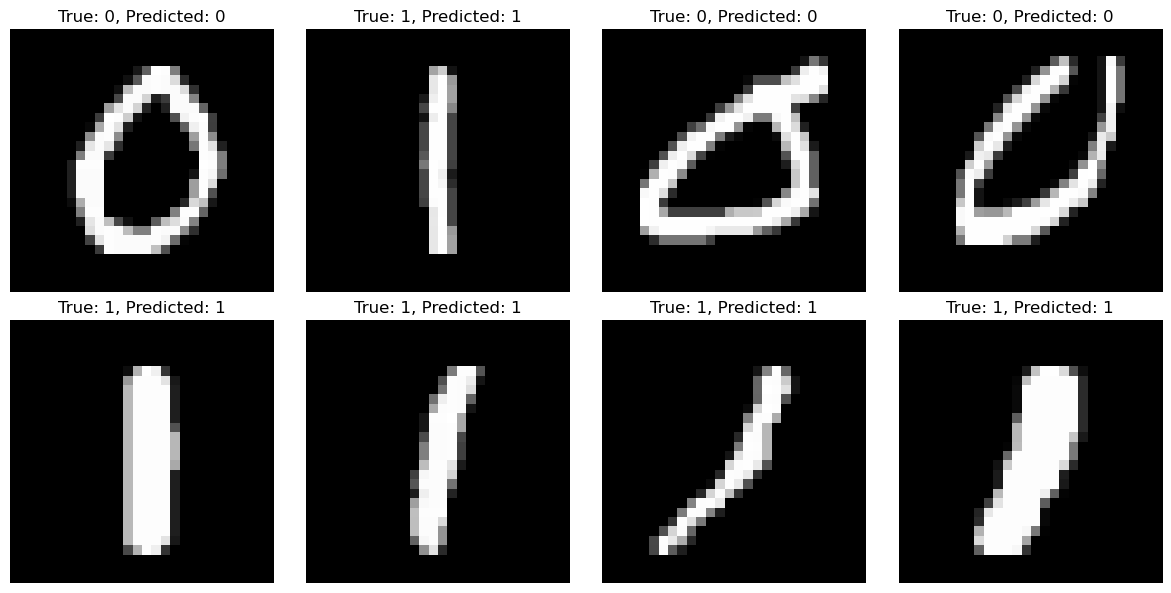

In [5]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Select 8 random samples from the test set
num_samples = 8
random_indices = random.sample(range(len(test_images_filtered)), num_samples)
sample_images = test_images_filtered[random_indices]
sample_labels = test_labels_filtered[random_indices]

# Predict classes using the trained model
predictions = model_binary.predict(sample_images).flatten().round()

# Plot the images with true labels and predicted classes
plt.figure(figsize=(12, 6))
for i in range(num_samples):
    plt.subplot(2, 4, i + 1)
    plt.imshow(sample_images[i].reshape(28, 28), cmap='gray')
    plt.title(f"True: {sample_labels[i]}, Predicted: {int(predictions[i])}")
    plt.axis('off')

plt.tight_layout()
plt.show()

### As the accuracy nears 100%, the model consistently aligns with nearly accurate predictions, resulting in equality between the true and predicted values.

### Multiclass classification

* For $K$ classes the output contains $K$ numbers $(\widehat y_1, \ldots, \widehat y_K)$
* $\widehat y_k$ is the probability of class $k$
* Now the output of the neural network is

$$
    \boldsymbol{\widehat y} = \boldsymbol x_L = \boldsymbol x_{\mathrm{out}} = \mathrm{SoftMax}(\boldsymbol x_{L-1}), 
$$

$$
    \mathrm{SoftMax}(\boldsymbol z)_i = \frac{e^{z_i}}{\sum_i
 e^{z_i}}$$
 
 * Finally, plug the predictions into the cross-entropy loss:
 
 $$
\mathcal L(\boldsymbol{\widehat y}, \boldsymbol y) = -\sum\limits_{k=1}^K y_k\log(\widehat y_k)
$$

IntSlider(value=128, description='Hidden Layer Size:', max=256, min=32, step=32)

IntSlider(value=10, description='Epochs:', max=20, min=5, step=5)

IntSlider(value=128, description='Batch Size:', max=256, min=64, step=64)

Button(description='Train and Plot', style=ButtonStyle())

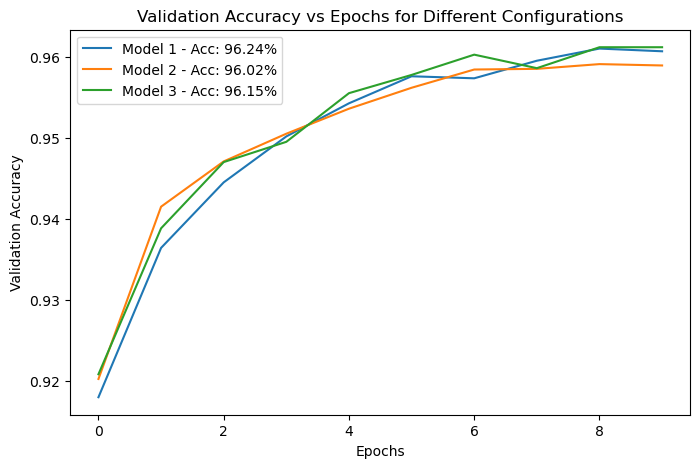

In [6]:
# Preprocess data
train_images = train_images.reshape((-1, 28 * 28)).astype('float32') / 255.0
test_images = test_images.reshape((-1, 28 * 28)).astype('float32') / 255.0

# One-hot encode labels for multiclass Softmax
train_labels_categorical = to_categorical(train_labels)
test_labels_categorical = to_categorical(test_labels)

def train_model(hidden_layer_size, epochs, batch_size):
    # Build the model for multiclass classification with Softmax
    model = Sequential([
        Dense(hidden_layer_size, activation='relu', input_shape=(28 * 28,)),
        Dense(hidden_layer_size // 2, activation='relu'),
        Dense(10, activation='softmax')  # Softmax output layer for 10 classes (digits 0-9)
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(train_images, train_labels_categorical, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0)

    # Evaluate model on test data
    test_loss, test_accuracy = model.evaluate(test_images, test_labels_categorical, verbose=0)
    
    return history, test_accuracy

# Create widgets for model configurations
hidden_layer_size_slider = widgets.IntSlider(value=128, min=32, max=256, step=32, description='Hidden Layer Size:')
epochs_slider = widgets.IntSlider(value=10, min=5, max=20, step=5, description='Epochs:')
batch_size_slider = widgets.IntSlider(value=128, min=64, max=256, step=64, description='Batch Size:')

# Create button to trigger training and plotting
train_button = widgets.Button(description='Train and Plot')

def on_train_button_clicked(b):
    history_list = []
    accuracy_list = []
    
    # Train models with different configurations
    for _ in range(3):  # Train 3 different configurations for comparison
        history, test_accuracy = train_model(hidden_layer_size_slider.value, epochs_slider.value, batch_size_slider.value)
        history_list.append(history)
        accuracy_list.append(test_accuracy * 100)
    
    # Plot the accuracy results
    plt.figure(figsize=(8, 5))
    for i, history in enumerate(history_list):
        plt.plot(history.history['val_accuracy'], label=f'Model {i+1} - Acc: {accuracy_list[i]:.2f}%')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.title('Validation Accuracy vs Epochs for Different Configurations')
    plt.show()

train_button.on_click(on_train_button_clicked)

# Display widgets and button
display(hidden_layer_size_slider, epochs_slider, batch_size_slider, train_button)


## Forward and Backward Passes in MLP

Let's delve into the concepts of both forward and backward passes in a Multilayer Perceptron (MLP). The forward pass computes the output of the network by propagating the input data through the layers, while the backward pass, also known as backpropagation, computes the gradients of the loss function with respect to the network's parameters.

#### Forward Pass:

The forward pass in an MLP involves feeding the input data through the network's layers to generate predictions. Each layer applies a weighted sum to the inputs, followed by an activation function to produce the output for the subsequent layer. This process continues until the final output is generated.

Mathematically, the forward pass can be represented as:

$$
z_i = W_i \cdot a_{i-1} + b_i \\
a_i = \text{activation_function}(z_i)
$$


Here, $z_i$ represents the weighted sum plus bias at layer $i$, $a_i$ denotes the activations at layer $i$, $W_i$ signifies the weights, $a_{i-1}$ signifies the activations from the previous layer, and $b_i$ denotes the bias at layer $i$.

The activations from the output layer obtained through this process represent the predicted output of the network for a given input.

#### Backward Pass:

The backward pass involves the application of the chain rule to calculate gradients of the loss function $L$ with respect to the weights ($W$) and biases ($b$) of the network. This process is crucial for updating the parameters during the training phase via optimization algorithms like gradient descent.

Mathematically, the backward pass can be represented as:

$$
\frac{\partial L}{\partial W_i} = \frac{\partial L}{\partial a_i} \cdot \frac{\partial a_i}{\partial W_i} \\
\frac{\partial L}{\partial b_i} = \frac{\partial L}{\partial a_i} \cdot \frac{\partial a_i}{\partial b_i}
$$

Here, $\frac{\partial L}{\partial W_i}$ and $\frac{\partial L}{\partial b_i}$ denote the gradients of the loss function with respect to the weights and biases of layer $i$ respectively. $\frac{\partial L}{\partial a_i}$ represents the gradient of the loss function with respect to the activations of layer $i$. The derivatives $\frac{\partial a_i}{\partial W_i}$ and $\frac{\partial a_i}{\partial b_i}$ indicate the sensitivity of the activations to the weights and biases of layer $i$ respectively.

Just like the forward pass, the backward pass plays a pivotal role in training neural networks by updating the network parameters to minimize the error or loss.

This formulation captures the essence of backpropagation, elucidating how gradients are computed with respect to weights and biases during the training of an MLP.

The subsequent sections will delve deeper into these concepts and demonstrate their application.


In [7]:
from jupyterquiz import display_quiz
display_quiz("#q_forward_pass")

<IPython.core.display.Javascript object>